# **Lab: Fluid-structure interation (elasticity)**
**Jacob Wahlgren**

# **Abstract**

We use FEniCS to solve the elasticity equations to examine how changing Young's modulus and Poisson's ratio affects an elastic material.

# **About the code**

In [40]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)
# Copyright (C) 2021 Jacob Wahlgren (jacobwah@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [41]:
import numpy as np
import time
from dolfin import *
from mshr import *
import dolfin.common.plotting as fenicsplot
from matplotlib import pyplot as plt

# **Introduction**

The elasticity equations describe how an elastic material is affected by stretching. We solve the equations using finite element method.

Young's modulus $E$ is a measure of how stretchable a material is. It is the ratio of tension to strain in the material. The formula below denotes tension by $\sigma_{xx}$ and strain by $u_{xx}$.

$\displaystyle E = \frac{\sigma_{xx}}{u_{xx}}$

Poisson's ratio $\nu$ is a measure of how much a material contracts in the transverse direction when it is stretched. In the formula below $u_{xx}$ denotes the extension along the stretching direction and $u_{yy}$ denotes extension in the transverse direction (usually negative when stretching).

$\displaystyle \nu = -\frac{u_{yy}}{u_{xx}}$

Young's modulus and Poisson's ratio are described in [Linear elasticity](http://www.cns.gatech.edu/~predrag/GTcourses/PHYS-4421-04/lautrup/7.7/elastic.pdf).

We examine how Poisson's ratio, Young's modulus and boundary conditions affect a modeled elastic material.

# **Method**

**Define domain and mesh**

The domain is rectangular with three cylinders cut out.

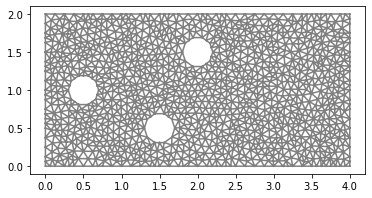

In [42]:
# Define rectangular domain 
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [43]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V) 

**Define boundary conditions**

The spring force at the boundary is set to 0, except for the objects where it is controlled by `object_force`. This parameter determines how much the cylinders will move.

In [44]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

def make_bcu(object_force):
    bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
    bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
    bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
    bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
    bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
    bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
    bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
    bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
    bcu_obj0 = DirichletBC(V.sub(0), object_force, dbc_objects)
    bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

    #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
    bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]
    
    return bcu

bcu05 = make_bcu(0.5)

# **Results**

**Define and solve variational problem**

In [45]:
def make_d(E, nu, bcu):
    d = Function(V)
    
    f = Expression(("0.0","0.0"), element = V.ufl_element())

    dim = u.geometric_dimension()
    mu = E*0.5/(1+nu)
    lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

    def epsilon(u):
        return 0.5*(grad(u) + grad(u).T)

    def sigma(u):
        #return 2.0*mu*epsilon(u)
        return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

    # Define variational problem on residual form: r(u,v) = 0
    residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

    au = lhs(residual)
    Lu = rhs(residual)

    A = assemble(au)
    b = assemble(Lu)

    [bc.apply(A, b) for bc in bcu]
    [bc.apply(d.vector()) for bc in bcu]

    solve(A, d.vector(), b, "bicgstab", "default")
    
    return d

**Visualize solution**

In [50]:
def visualize(E, nu, object_force=None):
    if object_force is None:
        bcu = bcu05
        ps = f"E={E:e}, $\\nu$={nu}"
    else:
        bcu = make_bcu(object_force)
        ps = f"E={E:e}, $\\nu$={nu}, $F_{{\\mathrm{{obj}}}}={object_force}$"
        
    d = make_d(E, nu, bcu)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    plt.sca(ax1)
    u1 = project(d, V)
    plot(u1, title=f"Displacement {ps}")
    
    plt.sca(ax2)
    m = Mesh(mesh)
    ALE.move(m, d)
    plot(m, title=f"Mesh {ps}")

**Varying Poisson's ratio**

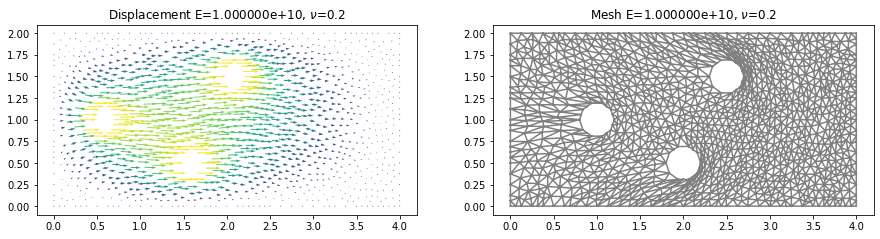

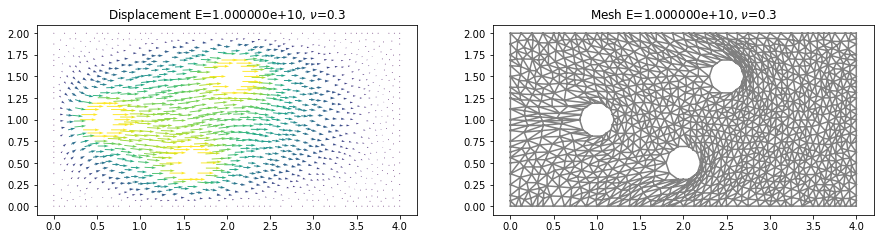

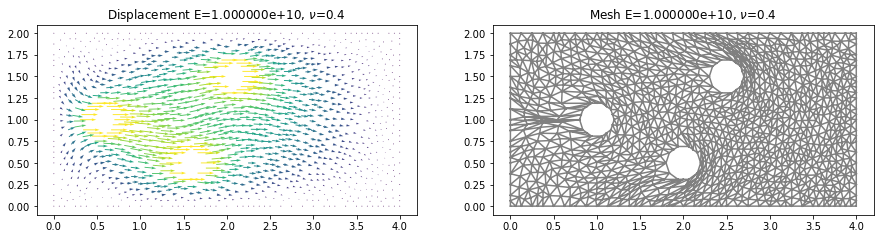

In [47]:
for E, nu in ((1.0e10, 0.2), (1.0e10, 0.3), (1.0e10, 0.4)):
    visualize(E, nu)

**Varying Young's modulus**

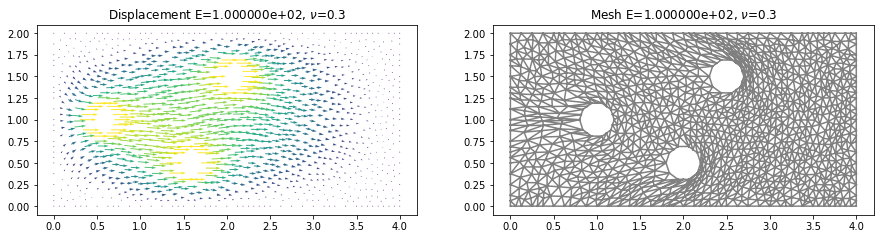

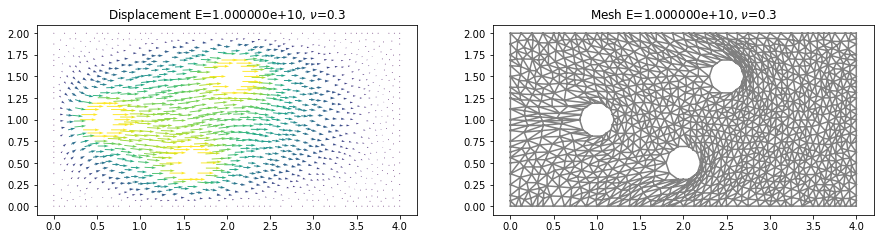

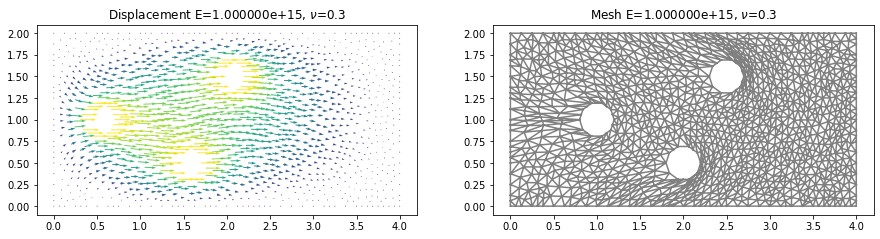

In [48]:
for E, nu in ((1.0e2, 0.3), (1.0e10, 0.3), (1.0e15, 0.3)):
    visualize(E, nu)

**Varying object force**

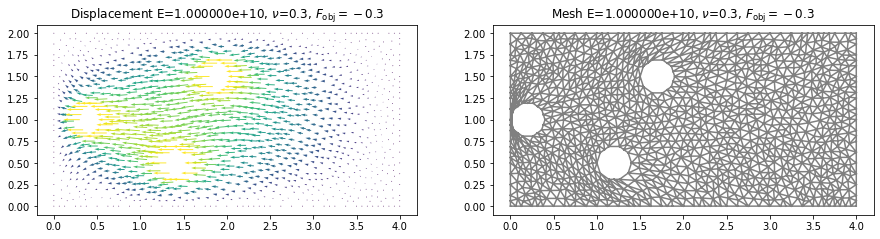

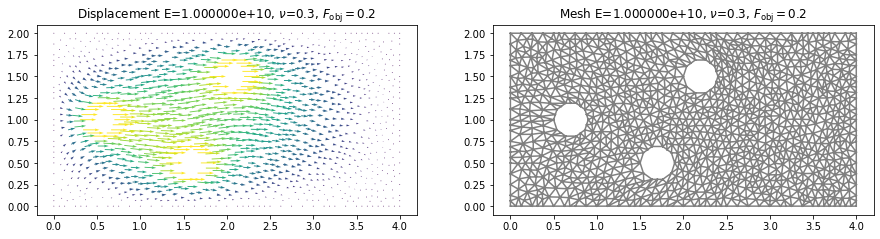

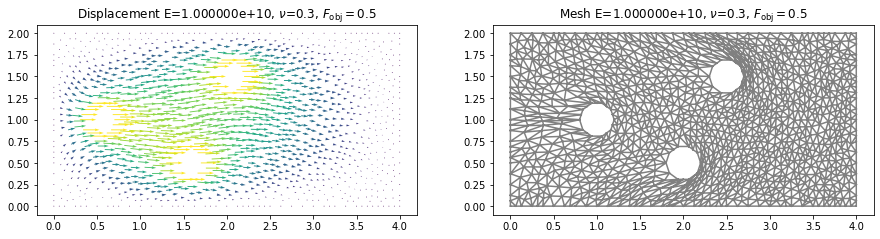

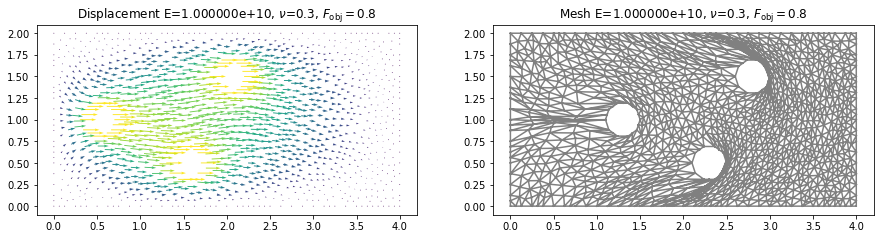

In [51]:
for object_force in (-0.3, 0.2, 0.5, 0.8):
    visualize(1.0e10, 0.3, object_force)

# **Discussion**

An elasticity equation was solved with a finite element method.

By default the cylinders are moved to the right. Therefore the areas of the mesh left of the cylinders are stretched out and the areas to the left of the cylinders are compressed together.

The visualizations show that the transverse contraction increases with $\nu$. The effect is clear when looking to the left of the left-most cylinder which is quite stretched. At $\nu=0.2$ the mesh looks quite "balanced" while at $\nu=0.4$ the mesh is almost collapsed. The diplacement plots also shows this, at lower $\nu$ the displacement is mostly in the $x$ direction, while for higher $\nu$ the displacement direction varies more.

Modifying $E$ does not change the results. The reason is that the spring forces are fixed at the boundaries, and the linear springs will distribute the forces equally to achieve the same stretching.

By changing the force on the object boundaries, the cylinders can be moved around. When the force is negative, they are moved to the left and when it is positive they are moved to the right. The mesh adapts by stretching and contracting to appear smooth. When the forces are large, e.g. $F_{\mathrm{obj}}$=0.8, the mesh is extremely compressed to the right of the cylinders. Regardless of the movement, the area between the cylinders stays almost the same since the distance between the cylinders is constant.